In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.io
import torch
# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [3]:
data = scipy.io.loadmat("data/lda/lda_on_grid.mat")
data = data["lda_on_grid"]
X = torch.tensor(data[:, :3])
X[:, 0] = 2.0 * X[:, 0] - 1.0
X[:, 1] = torch.log2(X[:, 1]) / 10.0
X[:, 2] = torch.log2(X[:, 2]) / 14.0
objective_X = -torch.tensor(data[:, 3]).unsqueeze(-1)
cost_X = torch.tensor(data[:, 4]).unsqueeze(-1) / 3600.0

In [4]:
dim = 3
maximize = True

In [5]:
from pandora_bayesopt.utils import fit_gp_model
objective_model = fit_gp_model(X, objective_X, input_standardize=True)

In [6]:
objective_model_state_dict = torch.load('data/lda/lda_objective_model_state.pth')

In [7]:
objective_model_state_dict

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.7281])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(0.0010)),
             ('mean_module.constant', tensor([-4.1485])),
             ('covar_module.raw_outputscale', tensor(13.8918)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[ 1.1911,  2.4436, -0.0256]])),
             ('covar_module.base_kernel.lengthscale_prior.concentration',
              tensor(3.)),
             ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.outputscale_prior.concentration', tensor(2.)),
             (

In [8]:
# Assuming objective_model_state_dict is your current state dictionary
# and objective_model is your SingleTaskGP model

# Set the outcome transform as trained if you're sure it was trained
# Wrap the boolean value in a torch.Tensor
objective_model_state_dict['outcome_transform._is_trained'] = torch.tensor(True)

In [9]:
# Assuming objective_model_state_dict is your current state dictionary
# and objective_model is your SingleTaskGP model

# List of keys to remove
keys_to_remove = [
    "likelihood.noise_covar.raw_noise",
    "likelihood.noise_covar.raw_noise_constraint.lower_bound",
    "likelihood.noise_covar.raw_noise_constraint.upper_bound"
]

# Remove the keys
for key in keys_to_remove:
    if key in objective_model_state_dict:
        del objective_model_state_dict[key]

In [10]:
objective_model.load_state_dict(objective_model_state_dict)

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/gpytorch/means/constant_mean.py:20: OldVersionWarning: You have loaded a GP model with a ConstantMean  from a previous version of GPyTorch. The mean module parameter `constant` has been renamed to `raw_constant`. Additionally, the shape of `raw_constant` is now *batch_shape, whereas the shape of `constant` was *batch_shape x 1. We have updated the name/shape of the parameter in your state dict, but we recommend that you re-save your model.
  warnings.warn(


<All keys matched successfully>

In [11]:
def objective_function(X):
    if X.ndim == 1:
        X = X.unsqueeze(0)
    posterior_X = objective_model.posterior(X)
    objective_X = posterior_X.mean.detach()
    return 0.001*objective_X

In [12]:
objective_model.eval()

SingleTaskGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
)

In [13]:
from pandora_bayesopt.utils import find_global_optimum_scipy
global_optimum_point, global_optimum_value = find_global_optimum_scipy(objective=objective_function, dim=dim, maximize=maximize)
print("global_optimum", global_optimum_point, global_optimum_value)
print()

global_optimum [0.15740116 0.53894863 0.96188552] -1.260419158428836



In [14]:
log_cost_X = torch.log(cost_X)
log_cost_model = fit_gp_model(X, log_cost_X, input_standardize=True)

In [15]:
log_cost_model_state_dict = torch.load('data/lda/lda_log_cost_model_state.pth')
log_cost_model_state_dict['outcome_transform._is_trained'] = torch.tensor(True)
for key in keys_to_remove:
    if key in log_cost_model_state_dict:
        del log_cost_model_state_dict[key]
log_cost_model.load_state_dict(log_cost_model_state_dict)

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/gpytorch/means/constant_mean.py:20: OldVersionWarning: You have loaded a GP model with a ConstantMean  from a previous version of GPyTorch. The mean module parameter `constant` has been renamed to `raw_constant`. Additionally, the shape of `raw_constant` is now *batch_shape, whereas the shape of `constant` was *batch_shape x 1. We have updated the name/shape of the parameter in your state dict, but we recommend that you re-save your model.
  warnings.warn(


<All keys matched successfully>

In [16]:
def cost_function(X):
    posterior_X = log_cost_model.posterior(X)
    cost_X = torch.exp(posterior_X.mean)
    return cost_X

In [17]:
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
budget = 50
seed = 42

In [18]:
from botorch.acquisition import ExpectedImprovement
from pandora_bayesopt.acquisition.gittins import GittinsIndex
from pandora_bayesopt.acquisition.ei_puc import ExpectedImprovementWithCost
from pandora_bayesopt.bayesianoptimizer import BayesianOptimizer
from botorch.utils.sampling import draw_sobol_samples

In [19]:
torch.manual_seed(seed)
init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with EI
EI_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
EI_optimizer.run_until_budget(budget=budget, acquisition_function_class=ExpectedImprovement)
EI_best_history = EI_optimizer.get_best_history()
EI_regret_history = EI_optimizer.get_regret_history(global_optimum_value)
EI_cost_history = EI_optimizer.get_cost_history()

Iteration 0, New point: [0.46207998 0.42763951 0.75728055], New value: -1.3001606003601691
Best observed value: -1.3001606003601691
Current acquisition value: tensor(0.1449)
Cumulative cost: 3.3852890869434953

Iteration 1, New point: [0.35701163 0.89689406 0.8197522 ], New value: -1.3289668830739483
Best observed value: -1.3001606003601691
Current acquisition value: tensor(0.1086)
Cumulative cost: 9.437366646695935

Iteration 2, New point: [0.76523178 0.9657478  0.38260981], New value: -1.514271174539011
Best observed value: -1.3001606003601691
Current acquisition value: tensor(0.1032)
Cumulative cost: 15.344241444692809

Iteration 3, New point: [0.88692453 0.48556423 0.74491144], New value: -1.3136372741140867
Best observed value: -1.3001606003601691
Current acquisition value: tensor(0.0965)
Cumulative cost: 19.631218736921316

Iteration 4, New point: [0.33292512 0.66903354 0.64005378], New value: -1.321415354538613
Best observed value: -1.3001606003601691
Current acquisition value: 

In [20]:
torch.manual_seed(seed)
init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with EIpu
EIpu_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
EIpu_optimizer.run_until_budget(budget=budget, acquisition_function_class=ExpectedImprovementWithCost)
EIpu_best_history = EIpu_optimizer.get_best_history()
EIpu_regret_history = EIpu_optimizer.get_regret_history(global_optimum_value)
EIpu_cost_history = EIpu_optimizer.get_cost_history()

Iteration 0, New point: [0.00919708 0.44715574 0.76750683], New value: -1.3212512747874339
Best observed value: -1.3212512747874339
Current acquisition value: tensor(0.0530)
Cumulative cost: 2.3186291506861214

Iteration 1, New point: [0.25809611 0.14320421 0.69532912], New value: -1.4076740834848591
Best observed value: -1.3212512747874339
Current acquisition value: tensor(0.0452)
Cumulative cost: 4.798472303976901

Iteration 2, New point: [0.28811084 0.92334259 0.44537208], New value: -1.4170173611904087
Best observed value: -1.3212512747874339
Current acquisition value: tensor(0.0355)
Cumulative cost: 7.270864538107427

Iteration 3, New point: [0.29346135 0.68914575 0.75684671], New value: -1.2944696014015744
Best observed value: -1.2944696014015744
Current acquisition value: tensor(0.0319)
Cumulative cost: 10.616836882489336

Iteration 4, New point: [0.00213566 0.07268092 0.90004993], New value: -1.2987534908216292
Best observed value: -1.2944696014015744
Current acquisition value:

In [21]:
torch.manual_seed(seed)

init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with GittinsIndex
GIstep_halving_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
GIstep_halving_optimizer.run_until_budget(budget=budget, acquisition_function_class=GittinsIndex, step_halving=True)
GIstep_halving_best_history = GIstep_halving_optimizer.get_best_history()
GIstep_halving_regret_history = GIstep_halving_optimizer.get_regret_history(global_optimum_value)
GIstep_halving_cost_history = GIstep_halving_optimizer.get_cost_history()

Iteration 0, New point: [0.00978448 0.79799588 0.58058514], New value: -1.3885089736353458
Best observed value: -1.323391271035382
Current acquisition value: tensor(-1.5191)
Cumulative cost: 1.8655014892745778
Gittins lmbda: 0.1

Iteration 1, New point: [0.02171271 0.43535999 0.78878455], New value: -1.3116253883850837
Best observed value: -1.3116253883850837
Current acquisition value: tensor(-1.3347)
Cumulative cost: 4.214634564300715
Gittins lmbda: 0.05

Iteration 2, New point: [0.29001176 0.13176091 0.69946911], New value: -1.4030161460806836
Best observed value: -1.3116253883850837
Current acquisition value: tensor(-1.2014)
Cumulative cost: 6.778657659447771
Gittins lmbda: 0.025

Iteration 3, New point: [0.31735589 0.67856102 0.76522741], New value: -1.2932243338303293
Best observed value: -1.2932243338303293
Current acquisition value: tensor(-1.2710)
Cumulative cost: 10.212683778022921
Gittins lmbda: 0.025

Iteration 4, New point: [0.         0.80232602 0.85119025], New value: -1.

In [22]:
torch.manual_seed(seed)

init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with GittinsIndex
GIstep_EIpu_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
GIstep_EIpu_optimizer.run_until_budget(budget=budget, acquisition_function_class=GittinsIndex, step_EIpu=True)
GIstep_EIpu_best_history = GIstep_EIpu_optimizer.get_best_history()
GIstep_EIpu_regret_history = GIstep_EIpu_optimizer.get_regret_history(global_optimum_value)
GIstep_EIpu_cost_history = GIstep_EIpu_optimizer.get_cost_history()

current lambda: 0.026490620987478636
Iteration 0, New point: [0.02038288 0.40508445 0.7946281 ], New value: -1.3131485018049132
Best observed value: -1.3131485018049132
Current acquisition value: tensor(-1.1207)
Cumulative cost: 2.345928266373729
Gittins lmbda: 0.026490620987478636

current lambda: 0.026490620987478636
Iteration 1, New point: [0.15739015 0.00244856 0.62895762], New value: -1.5547306276308896
Best observed value: -1.3131485018049132
Current acquisition value: tensor(-1.1708)
Cumulative cost: 4.6583788920606555
Gittins lmbda: 0.026490620987478636

current lambda: 0.026490620987478636
Iteration 2, New point: [0.41879996 0.43612238 0.7673813 ], New value: -1.2985674962163165
Best observed value: -1.2985674962163165
Current acquisition value: tensor(-1.2398)
Cumulative cost: 7.919894944602256
Gittins lmbda: 0.026490620987478636

current lambda: 0.026490620987478636
Iteration 3, New point: [0.         0.79899075 0.84042789], New value: -1.2775495467206321
Best observed value

In [23]:
torch.manual_seed(seed)

init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with GittinsIndex
GIlmbda_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
GIlmbda_optimizer.run_until_budget(budget=budget, acquisition_function_class=GittinsIndex, lmbda=0.001)
GIlmbda_best_history = GIlmbda_optimizer.get_best_history()
GIlmbda_regret_history = GIlmbda_optimizer.get_regret_history(global_optimum_value)
GIlmbda_cost_history = GIlmbda_optimizer.get_cost_history()

Iteration 0, New point: [0.20440775 0.14425439 0.72190245], New value: -1.3900921223413514
Best observed value: -1.323391271035382
Current acquisition value: tensor(-0.4175)
Cumulative cost: 2.410379154908727

Iteration 1, New point: [0.         0.73555452 0.88833833], New value: -1.2695617075891803
Best observed value: -1.2695617075891803
Current acquisition value: tensor(-0.6064)
Cumulative cost: 5.764523710002015

Iteration 2, New point: [0.         0.0525902  0.98231287], New value: -1.2730501020423557
Best observed value: -1.2695617075891803
Current acquisition value: tensor(-0.6532)
Cumulative cost: 9.32215278330258

Iteration 3, New point: [0.         0.38794626 0.45307994], New value: -1.8721305138559716
Best observed value: -1.2695617075891803
Current acquisition value: tensor(-0.7325)
Cumulative cost: 11.283891823979097

Iteration 4, New point: [0.53786049 0.         1.        ], New value: -1.2794281311909401
Best observed value: -1.2695617075891803
Current acquisition value

Text(0.5, 1.0, 'Performance of EI vs Gittins on LDA')

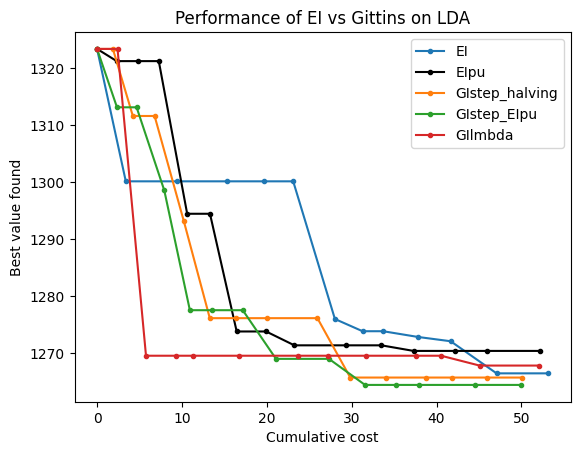

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(EI_cost_history, -1000*np.array(EI_best_history),'.-',label="EI")
plt.plot(EIpu_cost_history, -1000*np.array(EIpu_best_history),'.-',color='black',label="EIpu")
plt.plot(GIstep_halving_cost_history, -1000*np.array(GIstep_halving_best_history),'.-',label="GIstep_halving")
plt.plot(GIstep_EIpu_cost_history, -1000*np.array(GIstep_EIpu_best_history),'.-',label="GIstep_EIpu")
plt.plot(GIlmbda_cost_history, -1000*np.array(GIlmbda_best_history),'.-',label="GIlmbda")
plt.legend()
plt.xlabel('Cumulative cost')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins on LDA")

Text(0.5, 1.0, 'Performance of EI vs Gittins on LDA')

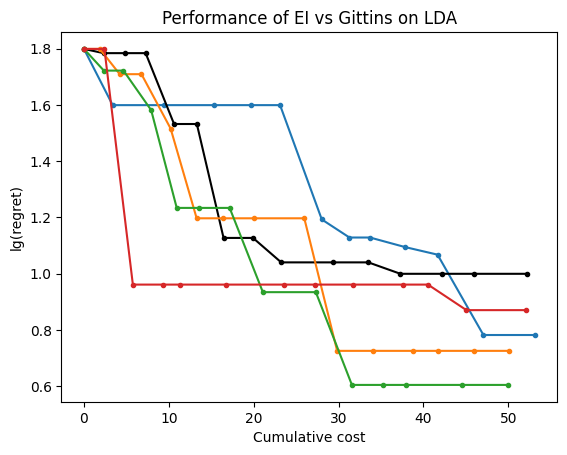

In [30]:
plt.plot(EI_cost_history, 3+np.log10(np.array(EI_regret_history)),'.-',label="EI")
plt.plot(EIpu_cost_history, 3+np.log10(np.array(EIpu_regret_history)),'.-',color='black',label="EIpu")
plt.plot(GIstep_halving_cost_history, 3+np.log10(np.array(GIstep_halving_regret_history)),'.-',label="GIstep_halving")
plt.plot(GIstep_EIpu_cost_history, 3+np.log10(np.array(GIstep_EIpu_regret_history)),'.-',label="GIstep_EIpu")
plt.plot(GIlmbda_cost_history, 3+np.log10(np.array(GIlmbda_regret_history)),'.-',label="GIlmbda")
plt.xlabel('Cumulative cost')
plt.ylabel('lg(regret)')
plt.title("Performance of EI vs Gittins on LDA")

In [26]:
from pandora_bayesopt.utils import find_global_optimum
global_optimum_point, global_optimum_value = find_global_optimum(objective=objective_function, dim=dim, maximize=maximize)
print("global_optimum", global_optimum_point, global_optimum_value)
print()

RuntimeError: prob_dist must be 1 or 2 dim

In [31]:
from pandora_bayesopt.acquisition.multi_step_ei import MultiStepLookaheadEI

torch.manual_seed(seed)

init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with GittinsIndex
MSEI_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
MSEI_optimizer.run_until_budget(budget=budget, acquisition_function_class=MultiStepLookaheadEI, batch_size=1, lookahead_batch_sizes=[1,1,1], num_fantasies=[4,4,2])
MSEI_best_history = MSEI_optimizer.get_best_history()
MSEI_regret_history = MSEI_optimizer.get_regret_history(global_optimum_value)
MSEI_cost_history = MSEI_optimizer.get_cost_history()

TypeError: MCSampler.__init__() missing 1 required positional argument: 'sample_shape'

In [32]:
from botorch.acquisition.multi_step_lookahead import qMultiStepLookahead

torch.manual_seed(seed)

init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with GittinsIndex
MSEI_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
MSEI_optimizer.run_until_budget(budget=budget, acquisition_function_class=qMultiStepLookahead, batch_sizes=[1,1,1], num_fantasies=[4,4,2])
MSEI_best_history = MSEI_optimizer.get_best_history()
MSEI_regret_history = MSEI_optimizer.get_regret_history(global_optimum_value)
MSEI_cost_history = MSEI_optimizer.get_cost_history()

RuntimeError: split_with_sizes expects split_sizes have only non-negative entries, but got split_sizes=[-51, 4, 16, 32]

In [33]:
from pandora_bayesopt.acquisition.budgeted_multi_step_ei import BudgetedMultiStepLookaheadEI

torch.manual_seed(seed)

init_x = draw_sobol_samples(bounds=bounds, n=1, q=2*(dim+1)).squeeze(0)

# Example usage with GittinsIndex
BMSEI_optimizer = BayesianOptimizer(objective=objective_function, dim=dim, maximize=maximize, cost=cost_function, initial_points=init_x, input_standardize=True)
BMSEI_optimizer.run_until_budget(budget=budget, acquisition_function_class=BudgetedMultiStepLookaheadEI, batch_size=1, lookahead_batch_sizes=[1,1,1], num_fantasies=[4,4,2])
BMSEI_best_history = BMSEI_optimizer.get_best_history()
BMSEI_regret_history = BMSEI_optimizer.get_regret_history(global_optimum_value)
BMSEI_cost_history = BMSEI_optimizer.get_cost_history()

ImportError: cannot import name 'ScalarizedObjective' from 'botorch.acquisition.objective' (/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraBayesOPT/pandorabayesopt_env/lib/python3.11/site-packages/botorch/acquisition/objective.py)